# Simple NN simulating sin(x)

In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

In [2]:
%matplotlib inline
plt.style.use("ggplot")

In [3]:
sample_size = 3000

In [4]:
x = np.linspace(-6, 6, sample_size, dtype='float32')

In [5]:
y = np.sin(x)
y_observed = y + np.random.normal(size=sample_size, scale=0.20)

min_y = min(y_observed)
max_y = max(y_observed)

y_observed = (y_observed - min_y) / (max_y - min_y)
y = (y - min_y) / (max_y - min_y)

y_observed = y # delete afterwards

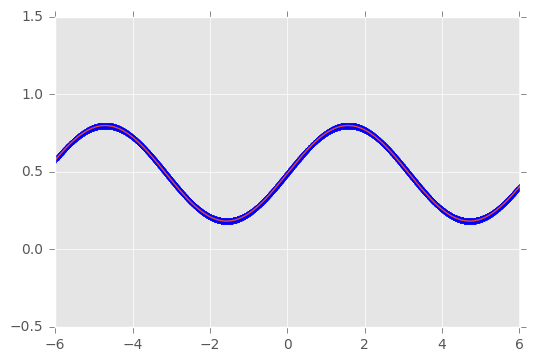

In [6]:
fig = plt.figure()
fig.add_subplot()
ax = fig.gca()
ax.plot(x, y)
ax.set_ylim(-0.5, 1.5)
ax.set_xlim(-6.01, 6.01)
ax.scatter(x, y_observed, marker='+')

In [7]:
neurons_number = {"layer_1": 20,
                  "layer_2": 20, 
                  "layer_3": 50}

give_x = tf.placeholder('float32', name="X")
give_y = tf.placeholder('float32', name="Y")

activation_f = tf.nn.tanh

hl_1 = {"weights": tf.Variable(tf.random_normal([1, neurons_number['layer_1']]), name="W1"),
        "biases": tf.Variable(tf.constant(0, shape=[neurons_number['layer_1']], dtype='float'), name="b1")}

hl_2 = {"weights": tf.Variable(tf.random_normal([neurons_number['layer_1'], neurons_number['layer_2']]), name="W2"),
        "biases": tf.Variable(tf.constant(0, shape=[neurons_number['layer_2']], dtype='float'), name="b2")}

hl_3 = {"weights": tf.Variable(tf.random_normal([neurons_number['layer_2'], neurons_number['layer_3']]), name="W3"),
        "biases": tf.Variable(tf.constant(0, shape=[neurons_number['layer_3']], dtype='float'), name="b3")}

output_layer = {"weights": tf.Variable(tf.random_normal([neurons_number['layer_3'], 1]), name="WO"),
                "biases": tf.Variable(tf.constant(0, shape=[1], dtype='float'), name="bO")}

l1 = tf.matmul(give_x, hl_1['weights']) + hl_1['biases']
l1 = activation_f(l1)

l2 = tf.matmul(l1, hl_2['weights']) + hl_2['biases']
l2 = activation_f(l2)

l3 = tf.matmul(l2, hl_3['weights']) + hl_3['biases']
l3 = activation_f(l3)

output = tf.matmul(l3, output_layer['weights']) + output_layer['biases']


x_feed_nn = x.reshape(sample_size, 1)
y_feed_nn = y_observed.reshape(sample_size,1)
output

<tf.Tensor 'add_3:0' shape=(?, 1) dtype=float32>

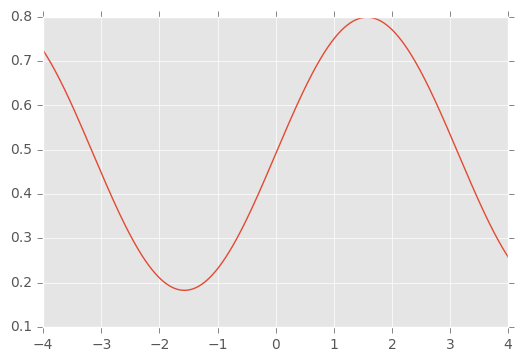

In [8]:
prediction = output
cost = tf.reduce_mean(abs(prediction - give_y)**2)

optimizer = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(cost)
# optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.01).minimize(cost) 

n_epochs = 2000

x_sin = np.linspace(-4, 4, 1000)
plt.plot(x_sin, (np.sin(x_sin) - min_y) / (max_y - min_y))
model_sample_size = 50
model_x = np.linspace(-3, 3, model_sample_size, dtype='float32')
model_x = np.random.uniform(-3, 3, size=model_sample_size)


In [9]:
# for index, op in enumerate(graph.get_operations()):
#     print("{0:15} - {1}".format(index, op.name))

### Functions for visualization of the tensorflow graph in Jupyter

From DeepDream tutorial availiable at:
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/deepdream/deepdream.ipynb

In [10]:
# boilerplate code
# from __future__ import print_function
# import os
# from io import BytesIO
# import numpy as np
# from functools import partial
# import PIL.Image
from IPython.display import clear_output, Image, display, HTML

In [11]:
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = tf.compat.as_bytes("<stripped %d bytes>"%size)
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:1000px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [12]:
show_graph(tf.get_default_graph())

#### Graph execution

start
 Epoch  400  completed out of  2000  loss:  0.0220701
 Epoch  800  completed out of  2000  loss:  0.012196
 Epoch  1200  completed out of  2000  loss:  0.00647448
 Epoch  1600  completed out of  2000  loss:  0.00348683
 Epoch  2000  completed out of  2000  loss:  0.0020737


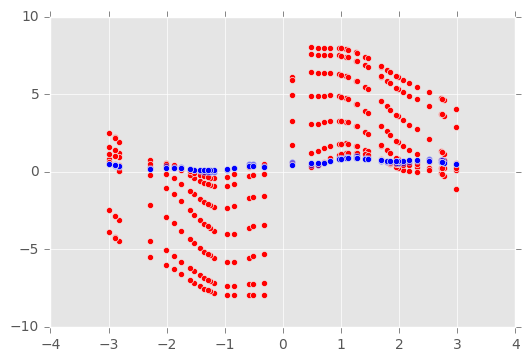

In [9]:

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print("start")
    for epoch in range(1, n_epochs + 1):
        _, epoch_loss = sess.run([optimizer, cost], feed_dict={give_x: x_feed_nn, give_y: y_feed_nn})
        if epoch % 400 == 0:
            print(" Epoch ", epoch, ' completed out of ', n_epochs, ' loss: ', epoch_loss)
        
        if epoch in [1, 5, 15, 30, 60, 120, 240]:
            m_y = tf.reduce_mean(output, axis=1).eval(feed_dict={give_x: model_x.reshape((model_sample_size, 1))}, session=sess)
            plt.scatter(model_x, m_y, c="red")
        
        if epoch % 1000 == 0:       
#             model_y = output.eval(feed_dict={give_x: model_x.reshape((model_sample_size, 1))}, session=sess)
            m_y = tf.reduce_mean(output, axis=1).eval(feed_dict={give_x: model_x.reshape((model_sample_size, 1))}, session=sess)
            plt.scatter(model_x, m_y, alpha=epoch/n_epochs)

# ax.set_ylim(-1.5, 1.5)
# ax.set_xlim(-6.01, 6.01)
# ax.scatter(x, y_observed, marker='+')


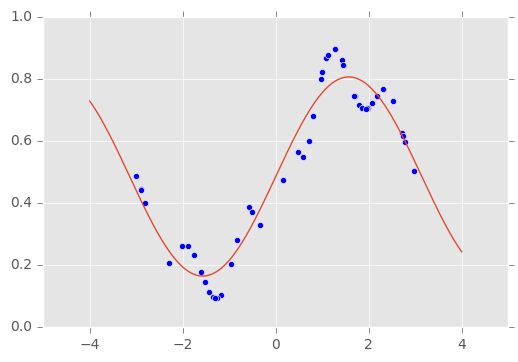

In [10]:
x_sin = np.linspace(-4, 4, 1000)
plt.plot(x_sin, (np.sin(x_sin) - min_y) / (max_y - min_y))
plt.scatter(model_x, m_y)

In [10]:
model_x.shape

(50,)

In [11]:
m_y.shape

(50,)

In [12]:
output

<tf.Tensor 'Add_3:0' shape=(?, 1) dtype=float32>